In [1]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.iolib.table import SimpleTable
import scipy as sp
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from scipy import stats
from math import sqrt
from sklearn import metrics
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit 

# Первичный анализ данных

In [2]:
df = pd.read_csv('master.csv')

Датасет представляет из себя данные о самоубийствах за промежуток от 1985 по 2016 года. В нем содержится довольно полная информация об инцедентах: присутствуют поля "страна", "год", "пол", "возрастная группа"(данные сгруппированы по возрастным группам и гендеру), "население"(число людей из данной возростной группы данного пола), "число самоубиств на 100 тыс. человек"(из данной группы), "страна-год", "ИЧР на данный год", "годовой ВВП", "ВВП на душу населения", "поколение"(его кодовое название, например, Boomers). Датасет взят с кэгла(https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016). Цель проекта-понять, какие факторы влияют на число самоубийств в большей степени и спрогнозировать статистику самоубийств на несколько лет вперед. В исследовании будут применятся анализ графиков, статистические гипотезы и анализ временных рядов. План действий следующий: изучить датасет; провести первичную обработку данных; понять, какая величина лучше подходит для прогноза числа самоубийств; провести анализ графиков и формулировку гипотез; перейти к анализу временного ряда и прогнозу; сделать выводы.

In [3]:
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


# Предобработка данных

Нам не нужны country-year, sex, HDI for year, gdp_for_year и geneation.
В country-year нет необходимости, так как уже присутствуют поля country и year. 
HDI for year не нужен, так как в этой колонке много значений NAN, и в рамках данного исследования есть более приоритетные меры качества жизни в стране(ВВП на душу населения).
gdp_for_year не нужен, так как достаточно gdb_per_capita.
generation не нужен, так как в рамках данного исследования достаточно поля age.
В первичной агрегации данных нет необходимости, так как в будущем будет производиться группировка по разным полям.

In [4]:
to_drop = [' gdp_for_year ($) ','generation', 'HDI for year', 'country-year']

In [5]:
df = df.drop(to_drop, axis = 1)

In [6]:
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
0,Albania,1987,male,15-24 years,21,312900,6.71,796
1,Albania,1987,male,35-54 years,16,308000,5.19,796
2,Albania,1987,female,15-24 years,14,289700,4.83,796
3,Albania,1987,male,75+ years,1,21800,4.59,796
4,Albania,1987,male,25-34 years,9,274300,3.28,796
...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,2309
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,2309
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,2309
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,2309


В будущем понадобится числовое значение возраста, поэтому его необходимо перевести из строки в число. Этот способ несколько наивен, но, так как поле может принимать немного значений, он применим.

In [7]:
df.loc[df['age'] == '15-24 years', 'age'] = (15 + 24) / 2
df.loc[df['age'] == '25-34 years', 'age'] = (25 + 34) / 2
df.loc[df['age'] == '35-54 years', 'age'] = (35 + 54) / 2
df.loc[df['age'] == '55-74 years', 'age'] = (55 + 74) / 2
df.loc[df['age'] == '75+ years', 'age'] = 75
df.loc[df['age'] == '5-14 years', 'age'] = (5 + 14) /2

In [8]:
df

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
0,Albania,1987,male,19.5,21,312900,6.71,796
1,Albania,1987,male,44.5,16,308000,5.19,796
2,Albania,1987,female,19.5,14,289700,4.83,796
3,Albania,1987,male,75,1,21800,4.59,796
4,Albania,1987,male,29.5,9,274300,3.28,796
...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,44.5,107,3620833,2.96,2309
27816,Uzbekistan,2014,female,75,9,348465,2.58,2309
27817,Uzbekistan,2014,male,9.5,60,2762158,2.17,2309
27818,Uzbekistan,2014,female,9.5,44,2631600,1.67,2309


Давайте выясним, сколько стран присутствует в статистике по годам:

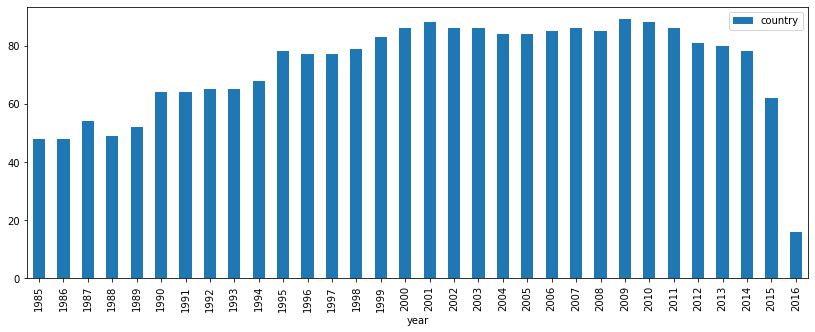

In [11]:
df.groupby(['year'])[['country']].nunique().plot.bar(figsize = (14,5))    

Хмм, 2016 год неинформативен. Лучше его удалить.

In [12]:
df = df[df['year'] != 2016]

# Визуальный анализ данных и проверка статистических гипотез

Посмотрим, как менялось число самоубийств в зависимости от времени, и поймем, что делать дальше.

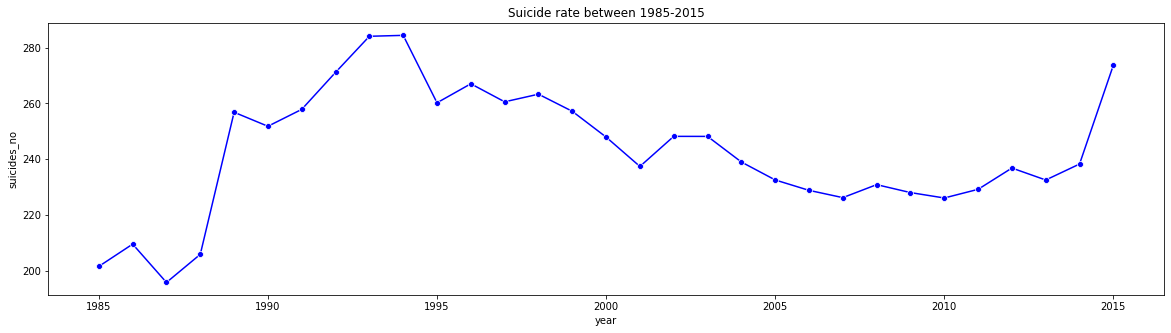

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Suicide rate between 1985-2015');
sns.lineplot(x = 'year', y = 'suicides_no', marker = 'o', data = df[['year','suicides_no']].groupby('year',as_index=False).mean(), color='BLUE')

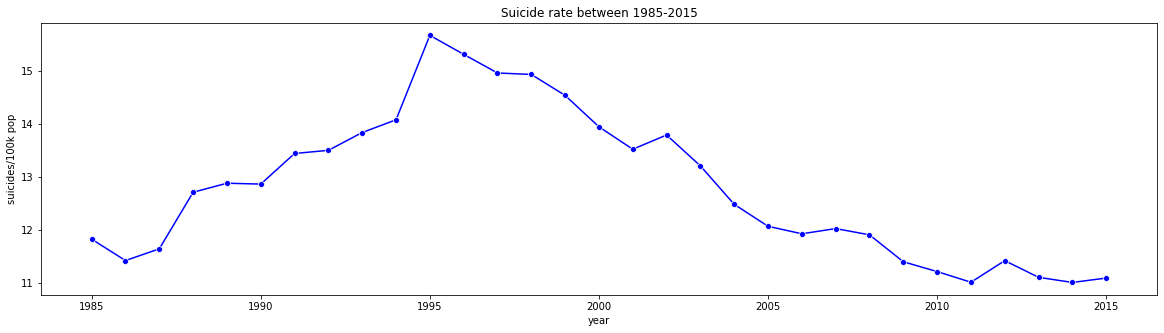

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Suicide rate between 1985-2015');
sns.lineplot(x='year', y='suicides/100k pop',  marker = 'o', data=df[['year','suicides/100k pop']].groupby('year',as_index=False).mean(), color='BLUE');

Пока не очевидно, какой параметр лучше исследовать: suicides/100k pop или suicides_no. Так как в графике suicides_no в 2015 году присутствует выброс(скорее всего, вызванный уменьшением числа обозреваемых стран) и сам график резко изменяется в зависимости от времени, а график suicides/100k po больше похож на нормальное распределение и более плавно меняет свое значение, то для дальнейшего исследования временного ряда лучше взять его.

Теперь посмотрим на страны:

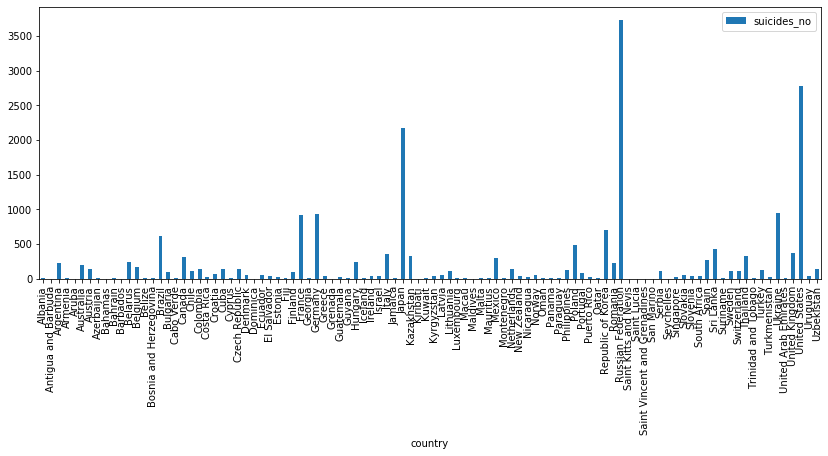

In [41]:
df.groupby(['country'])[['suicides_no']].mean().plot.bar(figsize=(14,5))

Не особо информативно: пара выбросов, а остальные значения слишком малы. Попробуем что-нибудь еще.

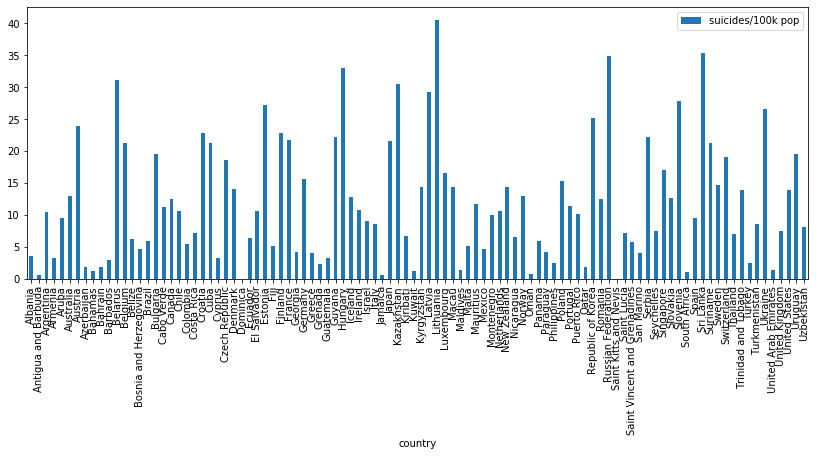

In [16]:
df.groupby(['country'])[['suicides/100k pop']].mean().plot.bar(figsize=(14,5))

Определенно, лучше анализировать suicides/100k pop, чем общее число самоубийств, так как в странах проживает разное число людей, и относительная мера гораздо более показательна, чем абсолютная.

Посмотрим, есть ли какая-нибудь связь между ВВП на душу населения и самоубийствами в зависимости от лет.

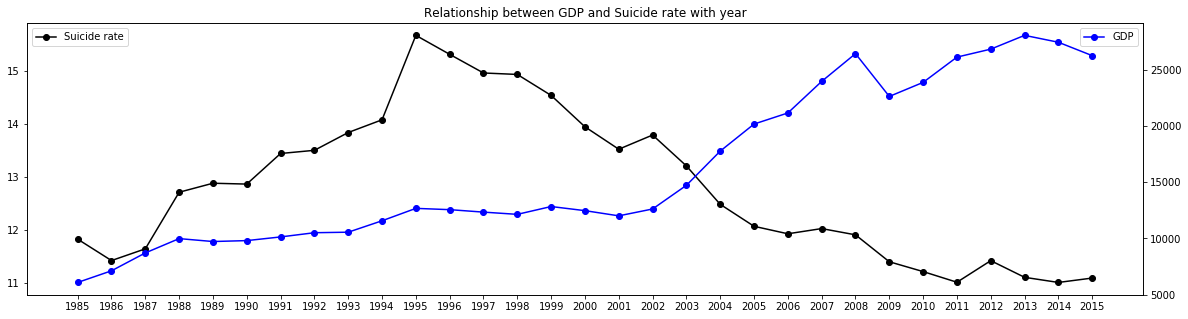

In [17]:
df1 = df[['year','suicides/100k pop', 'gdp_per_capita ($)']].groupby('year').mean().reset_index()
fig, ax = plt.subplots(figsize=(20, 5))
SR = ax.plot(df1['year'],df1['suicides/100k pop'],marker='o',color='BLACK', label='Suicide rate')
plt.legend(loc='upper left')
ax2 = ax.twinx()
GDP = ax2.plot(df1['year'],df1['gdp_per_capita ($)'],marker='o',color='BLUE', label='GDP') 
plt.legend(loc='upper right')
ax.set(xticks=df['year'].unique());
plt.title('Relationship between GDP and Suicide rate with year');

Никакой гипотезы относительно их взаимосвязи выдвинуть нельзя, однако давайте вглядимся в график самоубийств...

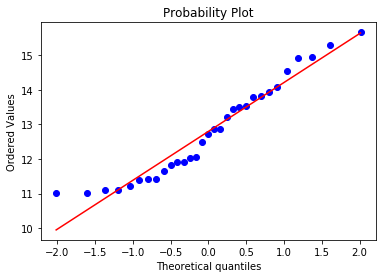

In [18]:
stats.probplot(df1['suicides/100k pop'], dist = "norm", plot = plt)
plt.show()

In [19]:
sp.stats.normaltest(df1['suicides/100k pop'])

NormaltestResult(statistic=3.562613369457247, pvalue=0.16841793428270227)

При уровне значимости 0.05 случайная величина "среднее число самоубийств за год на сто тысяч человек по миру" имеет нормальное распределение.

Может быть, в странах с низким ВВП число самоубийств в среднем больше, и, может, это даже можно статистически доказать?

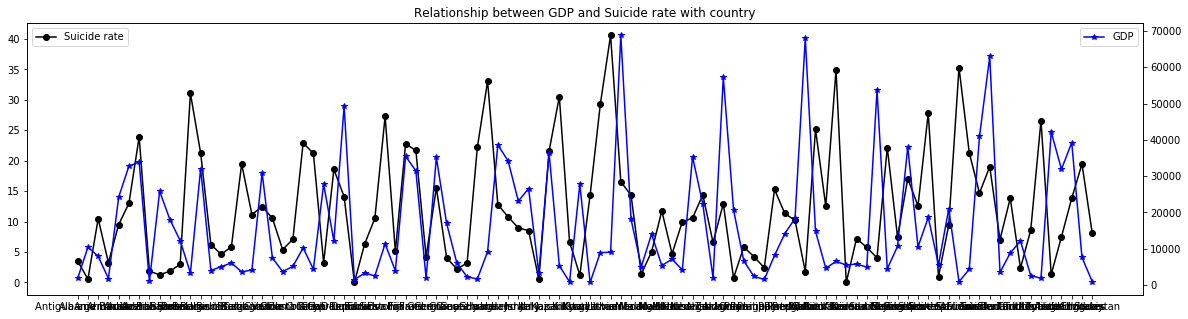

In [20]:
df1 = df[['country','suicides/100k pop', 'gdp_per_capita ($)']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(figsize=(20, 5))
SR = ax.plot(df1['country'],df1['suicides/100k pop'], marker='o', color='BLACK', label = 'Suicide rate')
plt.legend(loc='upper left')
ax2 = ax.twinx()
GDP = ax2.plot(df1['country'],df1['gdp_per_capita ($)'], marker='*',color='BLUE', label = 'GDP') 
plt.legend(loc='upper right')
ax.set(xticks=df['country'].unique());
plt.title('Relationship between GDP and Suicide rate with country');

В некоторых местах наблюдаются резкие увеличения числа самоубийств и падения ВВП(и наоборот). Может быть, эти случайные величины антикоррелируют?

In [21]:
sp.stats.pearsonr(df1['suicides/100k pop'],df1['gdp_per_capita ($)'])

(0.041806829398262635, 0.6796119016613634)

Нет, значение корреляции Пирсона близко к нулю, значит, между данными случайными величинами нет линейной зависимости, и наша гипотеза не подтвердилась. Впрочем, из графика можно сделать вывод, что если жить в странах с высоким ВВП, то вероятность совершить суицид, в среднем, как минимум не выше, чем та же вероятность, если жить в странах с низким ВВП.

Исследуем зависимость числа самоубийств от возраста:

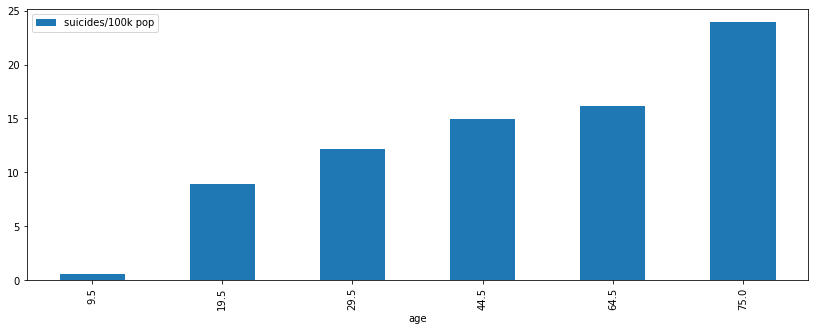

In [22]:
k = df.groupby(['age'])[['suicides/100k pop']].mean()
k.plot.bar(figsize=(14,5))

Из графика видно, что в среднем люди старшего возраста совершают суицид чаще. Но есть ли статистическая зависимость между возрастом и числом самоубийств? Будем исходить из числа самоубийств и общего числа людей. Применим критерий хи-квадрат независимости возраста от числа самоубийств, проверяя при этом условия его применимости. Пусть уровень значимости равен 0.05. Найдем среднее значение хи-квадрат, сгруппировав данные по годам.

In [23]:
chi_val = []
p_val = []
for year in df['year'].unique():
    cur = df[df['year'] ==  year][['suicides_no','population','age']]\
    .groupby('age').mean()
    cur['survived'] = cur['population'] - cur['suicides_no']
    assert(cur['survived'].all() >= 1)
    assert(len(cur[cur['survived'] < 5]['survived']) < 0.2 * len(cur['survived']))
    assert(cur['suicides_no'].all() >= 1)
    assert(len(cur[cur['suicides_no'] < 5]['suicides_no']) < 0.2 * len(cur['suicides_no']))
    k = sp.stats.chi2_contingency(cur[['survived', 'suicides_no']])
    chi_val.append(k[0])
    p_val.append(k[1])

In [24]:
np.mean(chi_val), np.mean(p_val)

(399.7762122031983, 5.599824027483157e-62)

Так как мы попали в критическую область, гипотеза независимости отвергается. Значит, число самоубийств зависит от возраста.

Но зависит ли число самоубийств от пола?

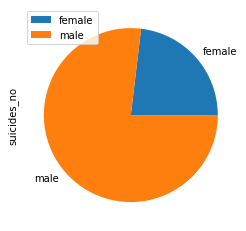

In [25]:
df[['suicides_no', 'sex']].groupby('sex').sum().plot.pie(y = 'suicides_no')

Как видно, мужчины совершают самоубийства гораздо чаще женщин.

# Исследование временных рядов.

Будем исследовать временной ряд, отражающий зависимость среднего числа самоубийств от года. Давайте еще раз нарисуем этот график:

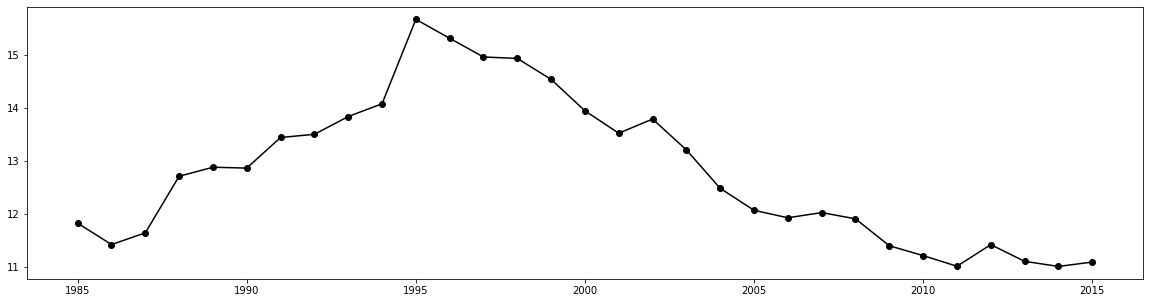

In [26]:
df2 = df[['year','suicides/100k pop']].groupby('year').mean().reset_index()
fig, ax = plt.subplots(figsize=(20, 5))
year_SR = ax.plot(df2['year'],df2['suicides/100k pop'],marker='o',color='BLACK')

Стационарен ли этот ряд?

In [27]:
border = 0.05
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df2['suicides/100k pop'].values, autolag = 'AIC' )
pvalue = dftest[1]
if pvalue < border:
     print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
     print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

Results of Dickey-Fuller Test:
p-value = 0.8520. The series is likely non-stationary.


Нет, значит, надо дифференцировать.

In [28]:
for i in range(len(df2['suicides/100k pop']) - 1, 0, -1):
    df2['suicides/100k pop'][i] = df2['suicides/100k pop'][i] -  df2['suicides/100k pop'][i - 1]

In [29]:
df2['suicides/100k pop'][0] = df2['suicides/100k pop'][2] - df2['suicides/100k pop'][1]

In [30]:
border = 0.05
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df2['suicides/100k pop'].values,autolag='AIC' )
pvalue = dftest[1]
if pvalue < border:
     print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
     print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

Results of Dickey-Fuller Test:
p-value = 0.0001. The series is likely stationary.


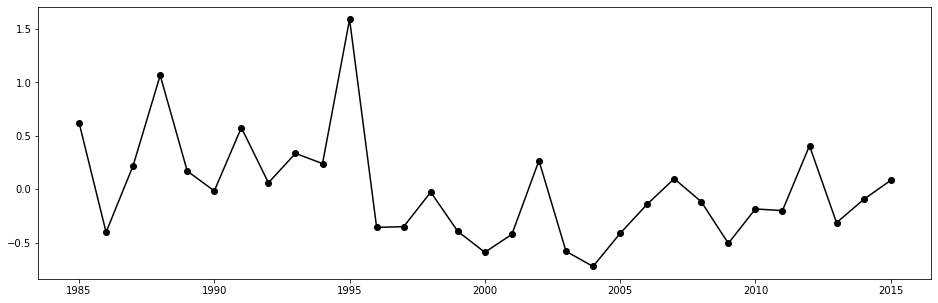

In [31]:
fig, ax = plt.subplots(figsize=(16, 5))
year_SR = ax.plot(df2['year'],df2['suicides/100k pop'],marker='o',color='BLACK', label='Suicide rate')

Ура, он стал стационарным! Можно перейти к предсказанию.

In [32]:
df3 = df2.groupby('year').mean()

Будем использовать линейную регрессию, валидацию и лаговые статистики.

In [33]:
train = df3.iloc[:25].dropna()

In [34]:
best = 0
min_err = float(np.inf)
for i in range(3, 9):
    features = []
    for period_mult in range(1,i,1):
        train["lag_period_{}".format(period_mult)] = train['suicides/100k pop'].shift(period_mult)
        features.append("lag_period_{}".format(period_mult))
    train['lagf_min'] = train[features].min(axis = 1)
    train['lagf_max'] = train[features].max(axis = 1)
    train['lagf_mean'] = train[features].mean(axis = 1)
    train['lagf_median'] = train[features].median(axis = 1)    
    features.extend(['lagf_min', 'lagf_max', 'lagf_mean', 'lagf_median'])
    tscv = TimeSeriesSplit(n_splits = 2) 
    model = LinearRegression()
    errors = []
    for train1, test1 in tscv.split(train):
        buf = train.iloc[train1].dropna()
        model.fit(buf[features], buf['suicides/100k pop'])
        forecast = model.predict(train.iloc[test1][features])
        errors.append(sqrt(metrics.mean_squared_error(train.iloc[test1]['suicides/100k pop'],forecast)))
    print(np.mean(errors))   
    if np.mean(errors) < min_err:
        min_err = np.mean(errors)
        best = i

0.7352895881928747
0.8584302034685001
1.0818328692322352
0.7761397786258053
1.7248861416995487
5.076125777179215


In [35]:
features = []
for period_mult in range(1, best, 1):
    df3["lag_period_{}".format(period_mult)] = df3['suicides/100k pop'].shift(period_mult)
    features.append("lag_period_{}".format(period_mult))
df3['lagf_min'] = df3[features].min(axis = 1)
df3['lagf_max'] = df3[features].max(axis = 1)
df3['lagf_mean'] = df3[features].mean(axis = 1)
df3['lagf_median'] = df3[features].median(axis = 1)    
features.extend(['lagf_min', 'lagf_max', 'lagf_mean', 'lagf_median'])

In [36]:
train = df3.iloc[:25].dropna()
test = df3.iloc[25:]

In [37]:
model = LinearRegression()
model.fit(train[features],train['suicides/100k pop'])
forecast = model.predict(test[features])

In [38]:
test['suicides/100k pop'] = forecast

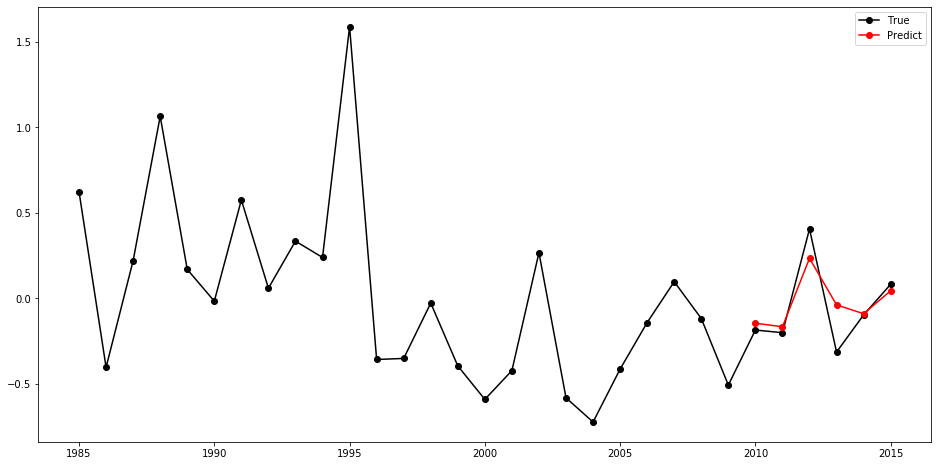

In [39]:
plt.figure(figsize=(16,8))
plt.plot(df3['suicides/100k pop'], label='True',marker='o',color='BLACK')
plt.plot(test['suicides/100k pop'], label='Predict',marker='o',color='RED')
plt.legend(loc='best')
plt.show()

In [40]:
sqrt(metrics.mean_squared_error(test['suicides/100k pop'],df3.iloc[25:]['suicides/100k pop']))

0.13531117200810558

# Выводы

Итак, мы получили следующие выводы: эмпирически можно сказать, что в странах с низким ВВП на душу населения зафиксировано больше случаев суицида, чем в богатых странах, однако, исходя из корреляции Пирсона, линейной зависимости между этими величинами нет. Далее, чем старше человек, тем в среднем больше вероятность, что он совершит самоубийство(критерий хи-квадрат). Можно сказать, что среднее число самоубийств имеет нормальное распределение в зависимости от времени. Еще удалось установить, что мужчины совершают самоубийства чаще женщин. Также удалось спрогнозировать с приемлемой точностью график самоубийств на пять лет. Прогноз временного ряда свидетельствует о том, что в течение ближайших нескольких лет(относительно 2010 года) число самоубийств будет возрастать, потом пойдет на спад, потом вновь будет возрастать.